# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

### Import modules

In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [76]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath = "C:\\Users\\abukar\\DeepLearning_ProJect\\test"
testpath  = "C:\\Users\\abukar\\DeepLearning_ProJect\\train"
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=5000 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 20
X_data shape: (20, 32, 32, 3)
y_data shape: (20,)


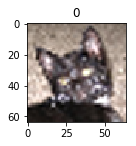

In [77]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[1],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

### The cnn_model_fn has to be defined here by the student

In [78]:
def cnn_model_fn(features, labels, mode):

#INPUT LAYER
    
    input_layer = tf.reshape(features["x"], [-1, img_size, img_size, num_channels])

  
#CONVLAYER1
    
    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
        padding="same", activation=tf.nn.relu)
  
#POOLINGLAYER1
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  
#CONVLAYER2
    
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)
  
#POOLINGLAYER2
  
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  
# Dense Layer
   
    layer_shape = pool2.get_shape()
    total_number_features = layer_shape[1:4].num_elements()
    pool2_flat = tf.reshape(pool2,[-1, total_number_features])
    
   
    dense = tf.layers.dense(inputs=pool2_flat, units=128, activation=tf.nn.relu)

    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
#LOGITSLAYER
    
    logits = tf.layers.dense(inputs=dropout,units=2)
    
    predictions = {
        
        "class": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits,name="softmax_tensor")
     
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
#DEFINE LOSS FUNCTION

    one_hot_labels = tf.one_hot(indices=tf.cast(labels,tf.int32),depth=2)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels,logits=logits)
    
#DEFINE OPTIMIZATION

    if mode ==tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)

#MODEL ACCURACY
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])
        
    }
    
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_metric_ops)





### Run the tensorflow model

This section will use the model defined by the student and run the training and evaluation step

In [79]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000228AD051908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/pets_convnet_model\model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tenso

INFO:tensorflow:loss = 0.001979793, step = 8001 (2.775 sec)
INFO:tensorflow:probabilities = [[0.00000084 0.99999917]
 [0.00000009 0.9999999 ]
 [0.00207481 0.99792516]
 [0.00098056 0.9990194 ]
 [0.00071614 0.99928385]
 [0.99392164 0.00607838]
 [0.00023242 0.9997676 ]
 [0.00024267 0.99975735]
 [0.9999888  0.00001119]
 [0.00006026 0.9999397 ]] (1.425 sec)
INFO:tensorflow:global_step/sec: 35.5823
INFO:tensorflow:probabilities = [[0.00000066 0.9999993 ]
 [0.01635273 0.9836473 ]
 [0.9993074  0.00069258]
 [0.00149761 0.9985024 ]
 [0.9925815  0.00741852]
 [0.00099452 0.9990055 ]
 [0.99545705 0.00454294]
 [0.00000001 1.        ]
 [0.99997246 0.00002757]
 [0.9999579  0.00004209]] (1.386 sec)
INFO:tensorflow:loss = 0.0031744323, step = 8101 (2.810 sec)
INFO:tensorflow:probabilities = [[0.9991873  0.00081276]
 [0.99885607 0.00114396]
 [0.00001959 0.99998045]
 [0.0000565  0.9999435 ]
 [0.00001176 0.9999882 ]
 [0.000886   0.999114  ]
 [0.99983704 0.00016298]
 [0.99997735 0.00002266]
 [0.9964838  0.0

INFO:tensorflow:loss = 0.00018899135, step = 9201 (2.711 sec)
INFO:tensorflow:probabilities = [[0.00005548 0.99994457]
 [0.0015272  0.99847275]
 [0.9999397  0.00006037]
 [0.9998785  0.00012149]
 [0.         1.        ]
 [0.00001472 0.99998534]
 [0.9999901  0.00000985]
 [0.99954575 0.00045424]
 [0.0007349  0.99926513]
 [0.00001694 0.9999831 ]] (1.377 sec)
INFO:tensorflow:global_step/sec: 36.6525
INFO:tensorflow:probabilities = [[0.00062765 0.9993724 ]
 [0.00000038 0.99999964]
 [0.999356   0.00064406]
 [0.9999689  0.00003108]
 [0.0000598  0.99994016]
 [0.00161182 0.9983882 ]
 [0.00004474 0.9999553 ]
 [0.00000314 0.9999969 ]
 [0.00004943 0.9999505 ]
 [0.95519215 0.04480787]] (1.351 sec)
INFO:tensorflow:loss = 0.004891656, step = 9301 (2.728 sec)
INFO:tensorflow:probabilities = [[0.00000003 1.        ]
 [0.         1.        ]
 [0.00000476 0.99999523]
 [0.00001435 0.9999857 ]
 [0.9989606  0.00103937]
 [0.00001907 0.9999809 ]
 [0.999995   0.00000496]
 [0.00002021 0.99997973]
 [0.9997191  0.

INFO:tensorflow:loss = 0.00030799952, step = 10401 (2.727 sec)
INFO:tensorflow:probabilities = [[0.99999964 0.00000032]
 [0.9999951  0.00000486]
 [0.0000065  0.99999344]
 [0.00003267 0.99996734]
 [0.99999774 0.00000225]
 [0.99860865 0.0013914 ]
 [0.9999999  0.00000015]
 [0.9978529  0.00214711]
 [0.99998295 0.00001703]
 [0.99996245 0.00003758]] (1.361 sec)
INFO:tensorflow:global_step/sec: 36.6042
INFO:tensorflow:probabilities = [[0.99997556 0.00002449]
 [0.00000012 0.9999999 ]
 [0.00000022 0.99999976]
 [0.99890316 0.00109687]
 [0.00000797 0.999992  ]
 [0.999603   0.00039703]
 [0.99999285 0.00000712]
 [0.9999449  0.00005504]
 [0.00061261 0.9993874 ]
 [0.9997303  0.0002697 ]] (1.371 sec)
INFO:tensorflow:loss = 0.00024720895, step = 10501 (2.733 sec)
INFO:tensorflow:probabilities = [[0.99992526 0.00007477]
 [0.00000004 1.        ]
 [0.9999707  0.00002929]
 [0.99930906 0.00069091]
 [0.9999999  0.00000006]
 [0.00000324 0.9999968 ]
 [0.99886036 0.00113964]
 [0.00000335 0.99999666]
 [0.0000209

INFO:tensorflow:loss = 0.00017096671, step = 11601 (2.744 sec)
INFO:tensorflow:probabilities = [[0.00005506 0.9999449 ]
 [0.00002394 0.99997604]
 [0.9999832  0.00001682]
 [0.999998   0.00000205]
 [0.9999914  0.00000862]
 [0.9980155  0.0019845 ]
 [0.99944705 0.00055291]
 [0.9999989  0.00000112]
 [0.9998832  0.00011677]
 [0.9996445  0.00035547]] (1.372 sec)
INFO:tensorflow:global_step/sec: 36.2647
INFO:tensorflow:probabilities = [[0.9998661  0.00013386]
 [0.00000791 0.99999213]
 [0.9999913  0.00000868]
 [0.00002163 0.9999784 ]
 [0.00000068 0.9999993 ]
 [0.00000825 0.9999918 ]
 [0.00017423 0.9998258 ]
 [0.99999666 0.00000332]
 [0.99985003 0.00014998]
 [0.         1.        ]] (1.385 sec)
INFO:tensorflow:loss = 5.085111e-05, step = 11701 (2.758 sec)
INFO:tensorflow:probabilities = [[0.99994683 0.00005316]
 [0.9999994  0.00000056]
 [0.9999465  0.00005358]
 [0.00017323 0.99982685]
 [0.00000098 0.99999905]
 [0.00000389 0.99999607]
 [0.9998878  0.0001122 ]
 [0.99997413 0.00002591]
 [0.00012856

UnboundLocalError: local variable 'train_op' referenced before assignment